# Inference Service

* Create an inference service to serve one of the registered models
* Fetch online features and calculate predictions from the inference service

**Prerequisites**
* Create a `Model Server`called `mnist` under the current workspace `feast`

In [1]:
!pip install --upgrade pip
!pip install --no-deps --ignore-requires-python "https://github.com/opendatahub-io/ml-metadata/releases/download/v1.14.0%2Bremote.1/ml_metadata-1.14.0+remote.1-py3-none-any.whl" # need a Python 3.11 compatible version
!pip install --no-deps --ignore-requires-python "model-registry==0.1.2" # ignore dependencies because of the above override
!pip uninstall ray --yes
!pip install "ray[serve]<=2.9.3,>=2.9.2"
!pip install kserve[storage]>=0.12.0
!pip install -q -r requirements.txt
!pip list | grep ray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.6 MB/s eta 0:00:00
Found existing installation: ray 2.9.3
Uninstalling ray-2.9.3:
  Successfully uninstalled ray-2.9.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 269.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 266.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 266.9 MB/s eta 0:00:00
  Attempting uninstall: starlette
    Found existing installation: starlette 0.37.2
    Uninstalling starlette-0.37.2:
      Successfully uninstalled starlette-0.37.2
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.110.2
    Uninstalling fastapi-0.110.2:
      Successfully uninstalled fastapi-0.110.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
codeflare-sdk 0.14.1 requires pydantic<2, but you have pydantic 2.7

## Imports and constants

In [2]:
import os

import boto3
import json
import matplotlib.pyplot as plt
import psycopg2
import requests
import time
from kubernetes import client 
from kserve import KServeClient
from kserve import constants
from kserve import utils
from kserve import V1beta1InferenceService
from kserve import V1beta1InferenceServiceSpec
from kserve import V1beta1PredictorSpec
from kserve import V1beta1SKLearnSpec
from kserve import V1beta1ModelSpec
from kserve import V1beta1ModelFormat
from kserve import V1beta1StorageSpec
from feast import FeatureStore
from model_registry import ModelRegistry
from model_registry.types import ContextState
from urllib.parse import urlparse

/opt/app-root/lib64/python3.9/site-packages/pydantic/_internal/_config.py:334: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
/opt/app-root/lib64/python3.9/site-packages/pydantic/_internal/_config.py:334: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
* 'json_loads' has been removed
  warnings.warn(message, UserWarning)
/opt/app-root/lib64/python3.9/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_version" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namesp

In [3]:
os.environ['accesskey'] = 'minio'
os.environ['secretkey'] = 'minio123'
os.environ['AWS_S3_ENDPOINT'] = 'http://minio-service.feast.svc.cluster.local:9000'
os.environ['AWS_S3_BUCKET'] = 'feast'
os.environ['AWS_DEFAULT_REGION'] = 'default'

Change this variable to use a different `Data Science Project`

In [4]:
%env MODEL_NAMESPACE=feast

env: MODEL_NAMESPACE=feast


In [5]:
%env REPO_PATH=mnist_demo/feature_repo/
# Disable Feast usage reporting
os.environ['FEAST_USAGE']='False'

env: REPO_PATH=mnist_demo/feature_repo/


## Shared functions

In [6]:
def get_model_registry():
    return ModelRegistry(server_address="modelregistry-sample.feast.svc.cluster.local", port=9090, author="feast-dev@redhat.com")

In [7]:
def select_model_for_test():
    registry = get_model_registry()

    models = registry._api.get_registered_models()
    for model in models:
        print(f"Model {model.name}")
        model_versions = registry._api.get_model_versions(model.id)
        for model_version in model_versions:
            print(f"Version {model_version.name}")
            model_artifacts = registry._api.get_model_artifacts(model_version.id)
            for model_artifact in model_artifacts:
                print(f"Artifact {model_artifact.name}: {model_artifact.uri}")

    # Update the logic to select the model and the version
    selected_model = models[0]
    live_model_versions = [m for m in registry._api.get_model_versions(selected_model.id) if m.state!=ContextState.ARCHIVED]
    selected_model_version = live_model_versions[0]
    selected_model_artifact = registry._api.get_model_artifacts(selected_model_version.id)[0]
    return (selected_model, selected_model_version, selected_model_artifact)

In [8]:
def create_data_connection_secret(selected_model):
    connection_secret = f'''
kind: Secret
apiVersion: v1
metadata:
  name: {selected_model.name}-s3-creds
  namespace: {os.environ['MODEL_NAMESPACE']}
  labels:
    opendatahub.io/dashboard: 'true'
    opendatahub.io/managed: 'true'
  annotations:
    opendatahub.io/connection-type: s3
    openshift.io/display-name: {selected_model.name}-s3
stringData:
  AWS_ACCESS_KEY_ID: {os.environ['accesskey']}
  AWS_DEFAULT_REGION: {os.environ['AWS_DEFAULT_REGION']}
  AWS_S3_BUCKET: {os.environ['AWS_S3_BUCKET']}
  AWS_S3_ENDPOINT: {os.environ['AWS_S3_ENDPOINT']}
  AWS_SECRET_ACCESS_KEY: {os.environ['secretkey']}
type: Opaque
'''

    with open("connection_secret.yaml", 'w') as file:
        file.write(connection_secret)

In [9]:
def create_inference_service(selected_model, selected_model_version, selected_model_artifact):
    # Normalize name v.simple_NN.20240419150600 to comply with DNS naming specs
    model_name = selected_model_version.name.lower().split(".")[1].replace("_","-")
    os.environ['MODEL_NAME'] = model_name
    kserve_version='v1beta1'
    api_version = constants.KSERVE_GROUP + '/' + kserve_version
    namespace = os.environ['MODEL_NAMESPACE']
    s3_secret_name = f"{selected_model.name}-s3-creds"
    service_account_name = f"{selected_model.name}-s3-creds"
    # s3://feast/v.simple_NN.20240419150600/simple_NN.onnx?endpoint=http://minio-service.feast.svc.cluster.local:9000&defaultRegion=default
    storage_path = urlparse(selected_model_artifact.uri).path.lstrip('/')
    model_format_name = selected_model_artifact.model_format_name
    model_format_version = selected_model_artifact.model_format_version
    storage_uri = selected_model_artifact.uri.split("?")[0]

    inference_service = V1beta1InferenceService(api_version=api_version,
                                   kind=constants.KSERVE_KIND,
                                   metadata=client.V1ObjectMeta(
                                       name=model_name, namespace=namespace,
                                       annotations={'serving.kserve.io/deploymentMode': 'ModelMesh'},
                                       labels={'modelregistry/registered-model-id': selected_model.id, 
                                               'modelregistry/model-version-id': selected_model_version.id,
                                                'opendatahub.io/dashboard': 'true',}
                                   ),
                                   spec=V1beta1InferenceServiceSpec(
                                       predictor=V1beta1PredictorSpec(
                                           model=V1beta1ModelSpec(
                                               name=model_name,
                                               storage=V1beta1StorageSpec(
                                                   key=s3_secret_name,
                                                   path=storage_path,
                                               ),
                                               model_format=V1beta1ModelFormat(name=model_format_name, version=model_format_version),
                                               runtime="mnist",
                                               # protocol_version='v2' # see https://kserve.github.io/website/master/modelserving/v1beta1/onnx/#create-the-inferenceservice
                                     )
                                   )))
    print(f"Creating InferenceService {inference_service.metadata.name} to serve {storage_uri}")
    return inference_service

In [10]:
def delete_existing_inference_service(KServe, inference_service):
    try:
        existing_inference_service = KServe.get(inference_service.metadata.name, inference_service.metadata.namespace)
        print(f"Deleting existing service with name {inference_service.metadata.name}")
        KServe.delete(inference_service.metadata.name, inference_service.metadata.namespace)
    except RuntimeError:
        print(f"No existing service to delete")

In [11]:
def wait_until_predictor_is_ready(KServe, inference_service):
    model_name = inference_service.metadata.name
    model_namespace = inference_service.metadata.namespace
    print(f"Waiting until model {model_name} is ready")

    total_iterations = 5 * 60 // 3
    iteration = 0
    is_predictor_ready = False
    while iteration < total_iterations:
        inference_service = KServe.get(model_name, model_namespace)
        if 'status' in inference_service and 'conditions' in inference_service['status']:
            is_predictor_ready = \
                bool([condition['status'] for condition in inference_service['status']['conditions'] if condition['type'] == 'PredictorReady'][0]) | False
            if is_predictor_ready == True:
                 break

        iteration += 1
        time.sleep(3)

    if is_predictor_ready:
        print(f"Predictor is ready for {model_name}")
    else:
        print(f"Predictor is not ready for {model_name}")

In [27]:
def inference_service_uris(KServe, inference_service):
    model_name = inference_service.metadata.name
    model_namespace = inference_service.metadata.namespace
    inference_service = KServe.get(model_name, model_namespace)
    rest_uri = inference_service['status']['components']['predictor']['restUrl']
    model_service_uri = f"{rest_uri}/v2/models/{model_name}"
    prediction_uri = f"{model_service_uri}/infer"
    return (rest_uri, model_service_uri, prediction_uri)

In [13]:
def inspect_service_metadata(model_service_uri):
    headers = {
        'Content-Type': 'application/json'
    }

    response = requests.get(model_service_uri, headers=headers)
    if response.status_code == 200:
        output_data = response.json()
        print(f"Metadata request to {model_service_uri} succeded.")
        return output_data
    else:
        print(f"Metadata request to {model_service_uri} failed with status code: {response.status_code}")

In [14]:
def fetch_online_features():
    store = FeatureStore(repo_path=os.environ['REPO_PATH'])    
    online_features = store.get_online_features(
        features = [f"mnist:feature_{feature_id+1}" for feature_id in range(28)],
        entity_rows=[{"image_id": f"{image_id}"} for image_id in range(10)]
    ).to_df()

    # Reshuffle dataframe with random order
    online_features = online_features.sample(frac=1, random_state=42)  
    return online_features

In [15]:
# Translates string array of floats to list of floats
def to_array(float_array_string):
    return [float(x) for x in float_array_string.strip('()').split(',')]

def to_model_data(online_features):
    image_ids = []
    images = []
    for index in range(len(online_features)):
        image_ids.append(online_features['image_id'].iloc[index])

        image = []
        image.append([to_array(online_features[f'feature_{id+1}'].iloc[index]) for id in range(28)])
        images.append(image)
    return (image_ids, images)

def generate_prediction_input(model_name, image):
    prediction_input = {
        "model_name": model_name,
        "inputs": [{
            "name": "x",
            "shape": [1, 28, 28],
            "datatype": "FP64",
            "data" : []
        }]
    }

    prediction_input['inputs'][0]['data'] = image
    return prediction_input

def validate_prediction(inference_service, image_id, image):
    headers = {
        'Content-Type': 'application/json'
    }
    
    prediction_input = generate_prediction_input(inference_service.metadata.name, image)
    response = requests.post(prediction_uri, data=json.dumps(prediction_input), headers=headers)
    if response.status_code == 200:
        output_data = response.json()
        predictions = output_data['outputs'][0]['data']
        max_prediction = max(predictions)
        max_index = predictions.index(max_prediction)
        print(f"The predicted number for image {image_id} is {max_index}")
        plt.figure(figsize = (1, 1))
        plt.imshow(image[0], cmap=plt.get_cmap('gray'))
        plt.show()
        assert max_index == image_id, f"The prediction failed: expected {image_id}, predicted {max_index}"
    else:
        # with open("data.json", 'w') as file:
        #     file.write(json.dumps(prediction_input))
        print(f"POST request to {prediction_uri} for {prediction_input} failed with status code: {response.status_code}")

## Selecting one of the registered models

Update the below logic to select a different model and version

In [16]:
selected_model, selected_model_version, selected_model_artifact = select_model_for_test()
print('=' * 30)
print(f"Creating inference service for model: {selected_model.id}\n{selected_model}")
print('=' * 30)
print(f"Creating inference service for model version: {selected_model_version.id}\n{selected_model_version}")
print('=' * 30)
print(f"Creating inference service for model artifact: {selected_model_artifact.id}\n{selected_model_artifact}")

INFO:absl:MetadataStore with gRPC connection initialized


Model mnist
Version v.simple_NN.20240419150600
Artifact mnist: s3://feast/v.simple_NN.20240419150600/simple_NN.onnx?endpoint=http://minio-service.feast.svc.cluster.local:9000&defaultRegion=default
Version v.convolutedNN.202404191508261
Artifact mnist: s3://feast/v.convolutedNN.20240419150826/convolutedNN.onnx?endpoint=http://minio-service.feast.svc.cluster.local:9000&defaultRegion=default
Creating inference service for model: 1
RegisteredModel(id='1', description='', external_id='', create_time_since_epoch=1713539173108, last_update_time_since_epoch=1713539173108, state=<ContextState.LIVE: 'LIVE'>, name='mnist')
Creating inference service for model version: 2
ModelVersion(name='v.simple_NN.20240419150600', id='2', description='demo20231121 e2e MNIST', external_id='', create_time_since_epoch=1713539173809, last_update_time_since_epoch=1713539173809, state=<ContextState.LIVE: 'LIVE'>, model_name='mnist', version='v.simple_NN.20240419150600', author='feast-dev@redhat.com', metadata={'AWS_

## Create the Inference Service

Fetch the existing services using `oc` CLI

In [17]:
!oc get inferenceservices -n $MODEL_NAMESPACE 

NAME        URL                                   READY   PREV   LATEST   PREVROLLEDOUTREVISION   LATESTREADYREVISION   AGE
simple-nn   grpc://modelmesh-serving.feast:8033   True                                                                  2m1s


Create a `Data Connection` to the S3 bucket.

The `Data Connection` is defined by a `Secret` with well-defined annotations, labels and keys to match the KServe definition.

In [18]:
create_data_connection_secret(selected_model)

In [19]:
!cat connection_secret.yaml


kind: Secret
apiVersion: v1
metadata:
  name: mnist-s3-creds
  namespace: feast
  labels:
    opendatahub.io/dashboard: 'true'
    opendatahub.io/managed: 'true'
  annotations:
    opendatahub.io/connection-type: s3
    openshift.io/display-name: mnist-s3
stringData:
  AWS_ACCESS_KEY_ID: minio
  AWS_DEFAULT_REGION: default
  AWS_S3_BUCKET: feast
  AWS_S3_ENDPOINT: http://minio-service.feast.svc.cluster.local:9000
  AWS_SECRET_ACCESS_KEY: minio123
type: Opaque


In [20]:
!oc delete -f connection_secret.yaml
!oc create -f connection_secret.yaml

secret "mnist-s3-creds" deleted
secret/mnist-s3-creds created


Create the `InferenceService` resource (see [Create the InferenceService](https://kserve.github.io/website/master/modelserving/v1beta1/onnx/#create-the-inferenceservice))

In [21]:
inference_service = create_inference_service(selected_model, selected_model_version, selected_model_artifact)

Creating InferenceService simple-nn to serve s3://feast/v.simple_NN.20240419150600/simple_NN.onnx


Delete the existing instance with same name

In [22]:
KServe = KServeClient()
delete_existing_inference_service(KServe, inference_service)

Deleting existing service with name simple-nn


Deploying the InferenceService with the `KServeClient`

In [23]:
created_inference_service = KServe.create(inference_service)

In [24]:
wait_until_predictor_is_ready(KServe, inference_service)

Waiting until model simple-nn is ready
Predictor is ready for simple-nn


## Inspecting the Inference Service

Verify resources using `oc` CLI

In [25]:
!oc get inferenceservices -n $MODEL_NAMESPACE $MODEL_NAME
!oc get routes -n $MODEL_NAMESPACE $MODEL_NAME

NAME        URL                                   READY   PREV   LATEST   PREVROLLEDOUTREVISION   LATESTREADYREVISION   AGE
simple-nn   grpc://modelmesh-serving.feast:8033   True                                                                  4s
NAME        HOST/PORT                                                  PATH                   SERVICES            PORT   TERMINATION          WILDCARD
simple-nn   simple-nn-feast.apps.feast-lab.4cuu.p1.openshiftapps.com   /v2/models/simple-nn   modelmesh-serving   8443   reencrypt/Redirect   None


Fetch REST service URI

In [29]:
rest_uri, model_service_uri, prediction_uri = inference_service_uris(KServe, inference_service)
print(f"REST URI for model {inference_service.metadata.name} is {rest_uri}")
print(f"Model service URI for model {inference_service.metadata.name} is {model_service_uri}")
print(f"Prediction URI for model {inference_service.metadata.name} is {prediction_uri}")

REST URI for model simple-nn is http://modelmesh-serving.feast:8008
Model service URI for model simple-nn is http://modelmesh-serving.feast:8008/v2/models/simple-nn
Prediction URI for model simple-nn is http://modelmesh-serving.feast:8008/v2/models/simple-nn/infer


Inspect service metedata

In [30]:
inspect_service_metadata(model_service_uri)

Metadata request to http://modelmesh-serving.feast:8008/v2/models/simple-nn succeded.


{'name': 'simple-nn__isvc-1cc0366e9a',
 'versions': ['1'],
 'platform': 'OpenVINO',
 'inputs': [{'name': 'x', 'datatype': 'FP64', 'shape': ['1', '28', '28']}],
 'outputs': [{'name': 'dense_2', 'datatype': 'FP32', 'shape': ['1', '10']}]}

## Validating online features

Fetching online features from `Feast`

In [31]:
online_features = fetch_online_features()

INFO:feast.infra.registry.registry:Registry cache expired, so refreshing


In [32]:
assert len(online_features) == 10, f"Found {len(online_features)} instead of 10"

In [33]:
online_features.head()

,image_id,feature_2,feature_4,feature_27,feature_6,feature_20,feature_15,feature_22,feature_28,feature_7,...,feature_19,feature_3,feature_9,feature_11,feature_18,feature_21,feature_13,feature_25,feature_5,feature_12
8,8,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.501...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.749...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50196078431...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7490196...",...,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2509803...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.749...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.74901960784...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.74901960784...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1..."
1,1,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1490196...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",...,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0627450...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0..."
5,5,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.776470588235294...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0196078...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.54509803921...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",...,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.996078431372549...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.482352941176470...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.349019607843137...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1529411...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.325..."
0,0,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.9921568627450981,0.9882...","(0.0,0.0,0.0,0.0,0.0,0.0,0.08235294117647059,0...","(0.0,0.0,0.0,0.0,0.0,0.7529411764705882,0.9921...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",...,"(0.0,0.0,0.0,0.0,0.0,0.9921568627450981,0.9882...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0039215...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.286274509803921...","(0.0,0.0,0.0,0.0,0.0,0.6705882352941176,0.9921...","(0.0,0.0,0.0,0.0,0.0,0.9921568627450981,0.9882...","(0.0,0.

For each online feature, invokes the prediction service and plot the image for visual verification

The predicted number for image 8 is 8


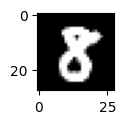

The predicted number for image 1 is 1


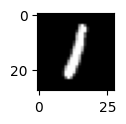

The predicted number for image 5 is 5


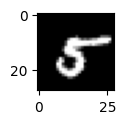

The predicted number for image 0 is 0


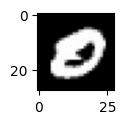

The predicted number for image 7 is 7


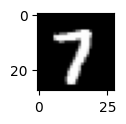

The predicted number for image 2 is 2


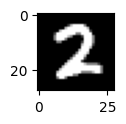

The predicted number for image 9 is 9


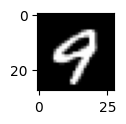

The predicted number for image 4 is 4


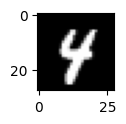

The predicted number for image 3 is 3


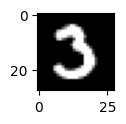

The predicted number for image 6 is 6


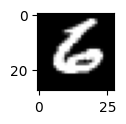

In [34]:
image_ids, images = to_model_data(online_features)
for i in range(len(image_ids)):
    image_id = image_ids[i]
    image = images[i]
    validate_prediction(inference_service, image_id, image)